In [89]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Testing python's functionality

In [21]:
# Test to see if python will pass the same memory address
# Spoilers it does which is very nice :P

class SharedVariable():
    def __init__(self, value):
        self.value = value
class UserClass():
    created = 1
    def __init__(self, shared_variable):
        self.SharedVariable_class = shared_variable
        self.id = UserClass.created
        UserClass.created += 1
# Make the object to be passed        
passed_obj = SharedVariable('hello')

# Make the objects that get the class passed to
obj1 = UserClass(passed_obj)
obj2 = UserClass(passed_obj)
display(obj1.id)
display(obj2.id) 

# Check if changing it in one object will affect the other
display(obj1.SharedVariable_class.value)
obj1.SharedVariable_class.value = 'goodbye'
display(obj2.SharedVariable_class.value)

## Map class

In [112]:
# Read in raw data
path_to_data = os.path.join(os.getcwd(), "data\\SRTM_RAMP2_TOPO_2000-02-11_rgb_3600x1800.CSV")
raw_data = pd.read_csv(path_to_data, header=None).to_numpy()
n_emptyValues = sum(np.isnan(raw_data).flatten())
raw_data = raw_data[420:560, 730:920]

# Make sure the data doesn't have outliers
clip_mask = raw_data < np.percentile(raw_data, 1)
data = raw_data
data[clip_mask] = np.percentile(raw_data, 1)

# Squish data and scale it
data = np.log(data)
dMax = np.max(data)
dMin = np.min(data)
scaled_data = (data - dMin) / (dMax-dMin)
# scaled_data = (scaled_data - 1) * -1

# Compute gradient and how many empty values it has
derivative_data = np.gradient(raw_data)

<AxesSubplot:>

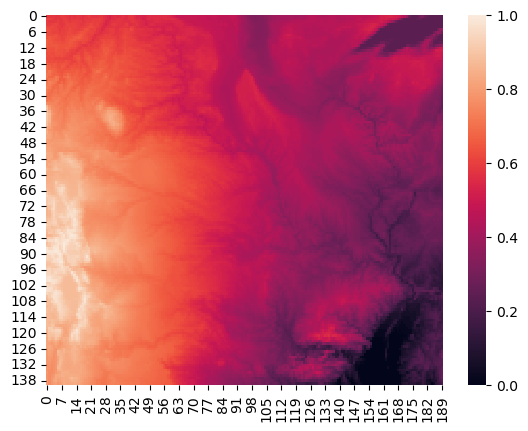

In [113]:
sns.heatmap(scaled_data)

In [116]:
class Map():
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.nNAN = 0
        self.data = self._data()
        self.gradientX, self.gradientY = self._gradient()
        
    def _data(self):           
        raw_data = pd.read_csv(path_to_data, header=None).to_numpy()
        self.nNAN = sum(np.isnan(raw_data).flatten())
        raw_data = raw_data[420:560, 730:920]

        # Make sure the data doesn't have outliers
        clip_mask = raw_data < np.percentile(raw_data, 1)
        data = raw_data
        data[clip_mask] = np.percentile(raw_data, 1)

        # Squish data and scale it
        data = np.log(data)
        dMax = np.max(data)
        dMin = np.min(data)
        
        return((data - dMin) / (dMax-dMin))

    def _gradient(self):
        # Compute gradient
        return(np.gradient(self.data))

In [117]:
mapData = Map(path_to_data)

## Cost class

In [125]:
class Cost():
    def __init__(self, a=1, b=1, c=-1):
        self.a = a
        self.b = b
        self.c = c
    def calculate_cost(self, gradient, current_height):
        return( self.a*np.abs(gradient) + self.b + self.c*current_height )

## Getting the surrounding pieces

In [245]:
def get_surrounding_values(position_vect, surrounding_map):
    # Works. Grabs a 1 pixel surrounding area
    # around a given position. If hits a boundry
    # Calls those values 0.
    posX, posY = position_vect
    #     leftLimit lowerLimit          rightLimit                 upperLimit
    borders =  [0, 0, surrounding_map.shape[0], surrounding_map.shape[1]]
    
    upperLimit = min((posY + 1) + 1, borders[3]) # not inclusive like the min and left limits
    lowerLimit = max((posY - 1), borders[1])
    rightLimit = min((posX + 1) + 1, borders[2]) # not inclusive like the min and left limits
    leftLimit = max((posX - 1), borders[0])
    
    excision = surrounding_map[leftLimit:rightLimit,lowerLimit:upperLimit]
    
    into_matrix = np.zeros([3,3])
    into_matrix[(leftLimit - (posX - 1)): (rightLimit - (posX - 1)), 
                (lowerLimit - (posY - 1)): (upperLimit - (posY - 1))] = excision
    # This has the issue of keeping the center value even if it 
    # is zero. I want to have a vector with only 8 values
    # into_matrix = -1
    # display(into_matrix)
    
    into_matrix = into_matrix.flatten()
    into_matrix = np.delete(into_matrix, 4)
    
    # When we have the gradient values selected, we can dot with this
    # pd.DataFrame({1: [-1, 1], 2: [0,1], 3: [1,1], 4:[1,0], 5: [1,-1], 6: [0,-1], 7:[-1,-1], 8:[-1,0]}, index = ['x','y']).T
    #      1  2  3  4  5  6  7  8
    #   x -1  0  1  1  1  0 -1 -1
    #   y  1  1  1  0 -1 -1 -1  0
    
    return(into_matrix)

In [282]:
# 8x2 of surrounding gradients
thing1 = np.concatenate( [get_surrounding_values([0,0], mapData.gradientX)[np.newaxis,:], 
                          get_surrounding_values([0,0], mapData.gradientY)[np.newaxis,:]], 
                        axis=0 ).T
thing1

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.02297167, -0.00292109],
       [ 0.        ,  0.        ],
       [ 0.00288723, -0.00557707],
       [ 0.        , -0.00846605]])

In [298]:
# 8x2
thing2 = pd.DataFrame({1: [-1, 1], 2: [0,1], 3: [1,1], 
                       4:[-1,0], 5: [1,0], 
                       6: [-1,-1], 7:[0,-1], 8:[1,-1]}, index = ['x','y']).T.to_numpy()
thing2 = thing2 / np.sqrt(np.sum(thing2*thing2, axis=1))[:,np.newaxis]

In [300]:
thing3 = np.sum(thing1*thing2, axis=1)
# mask_thing3 = thing3 <= 0
# thing3[mask_thing3] = -1
thing3

array([0.        , 0.        , 0.        , 0.        , 0.02297167,
       0.        , 0.00557707, 0.0059864 ])

<AxesSubplot:>

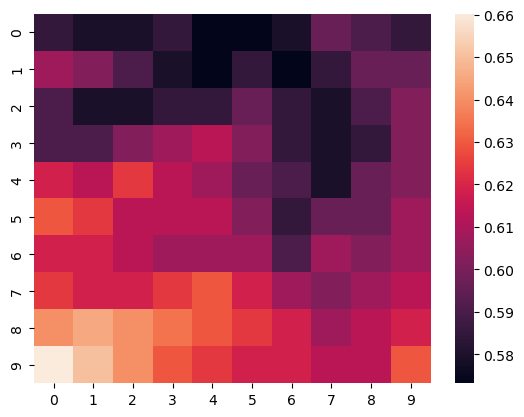

In [292]:
sns.heatmap(mapData.data[0:10,0:10])

<AxesSubplot:>

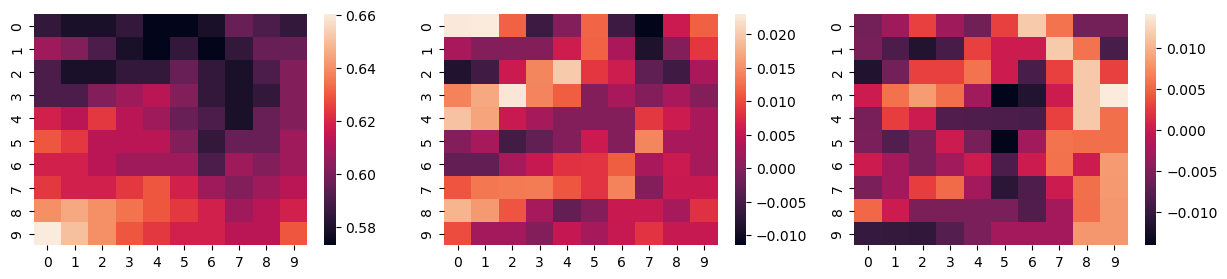

In [293]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(15,3))

sns.heatmap(mapData.data[0:10,0:10], ax = axes[0])
sns.heatmap(mapData.gradientX[0:10,0:10], ax = axes[1])
sns.heatmap(mapData.gradientY[0:10,0:10], ax = axes[2])